In [1]:
#Set GPU for computation
import tensorflow as tf
devices = tf.config.list_physical_devices()
print(devices)
tf.config.set_visible_devices(devices[1], 'GPU')
tf.config.experimental.set_memory_growth(devices[1], True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
#importing the image and annotations folders
import os
os.environ['GIT_PYTHON_GIT_EXECUTABLE'] = 'C:\Program Files\Git\bin\git.exe'
import cv2 as cv
import io
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import pandas as pd
import numpy as np

%matplotlib inline

#Plot RC
plt.rc('figure', autolayout = True)




In [2]:
#Images and annotations folder paths
image_folder_path = r'C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\dataset\JPEGImages'
anno_folder_path = r'C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\dataset\Annotations'
#Empty list to store images and corresponding annotations in tuple/list format
images = []
annotes = []
yolo_anno_filename = []
img_size = 640

sample_img = cv.imread(r"C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle - Copy\dataset\JPEGImages\000001.jpg")
a_scaling = min(img_size/sample_img.shape[0], img_size/sample_img.shape[1])
  
#Resizing images

a_new_h = int(sample_img.shape[0]*a_scaling)
a_new_w = int(sample_img.shape[1]*a_scaling)

#Padding
a_pad_h = (img_size - a_new_h)//2
a_pad_w = (img_size - a_new_w)//2

print(a_scaling,a_pad_h)
#Reading each image and corresponding annotations

for img in os.listdir(image_folder_path):
  #reading images using openCV
  img_path = os.path.join(image_folder_path, img)
  image = cv.imread(img_path)
  
    
  scaling = min(img_size/image.shape[0], img_size/image.shape[1])
  
  #Resizing images
  
  new_h = int(image.shape[0]*scaling)
  new_w = int(image.shape[1]*scaling)
  image_resized = cv.resize(image, (new_w,new_h))

  #Padding
  pad_h = (img_size - new_h)//2
  pad_w = (img_size - new_w)//2
  
  img_padded = cv.copyMakeBorder(image_resized,pad_h,img_size-new_h-pad_h,pad_w,img_size-new_w-pad_w,cv.BORDER_CONSTANT,value = (0,0,0))
  images.append(img_padded)
  cv.imwrite(img_path,img_padded)

  #reading annotations
  anno_filename = os.path.splitext(img)[0] + ".xml"
  yolo_filename = os.path.splitext(img)[0] + ".txt"
  anno_path = os.path.join(anno_folder_path, anno_filename)
  yolo_anno_filename.append(yolo_filename)

  if not os.path.exists(anno_path):
    raise ValueError(f"No file was found in the given path")

  #Function to get Bouding boxes from the annotations
  boxes = []
  tree = ET.parse(anno_path)
  root = tree.getroot()
  for objects in root.findall('object'):
    label = objects.find('name').text
    xmin = int(objects.find('bndbox/xmin').text)
    xmin_scaled = (xmin * a_scaling) + a_pad_w
    ymin = int(objects.find('bndbox/ymin').text)
    ymin_scaled = (ymin * a_scaling) + a_pad_h
    xmax = int(objects.find('bndbox/xmax').text)
    xmax_scaled = (xmax * a_scaling) + a_pad_w
    ymax = int(objects.find('bndbox/ymax').text)
    ymax_scaled = (ymax * a_scaling) + a_pad_h
    boxes.append([label,xmin_scaled,ymin_scaled,xmax_scaled,ymax_scaled])
#     boxes.append([label,xmin,ymin,xmax,ymax])
  annotes.append(boxes)
print(annotes[1])
# plt.imshow(images[1])


0.6837606837606838 136
[['window', 0.0, 138.05128205128204, 134.7008547008547, 218.05128205128204], ['window', 176.4102564102564, 138.73504273504273, 280.34188034188037, 213.26495726495727], ['window', 323.4188034188034, 136.68376068376068, 436.9230769230769, 215.31623931623932], ['window', 162.05128205128204, 283.69230769230774, 274.1880341880342, 411.55555555555554], ['window', 322.7350427350427, 285.7435897435897, 443.7606837606838, 417.02564102564105], ['window', 0.0, 285.0598290598291, 112.82051282051282, 419.0769230769231]]


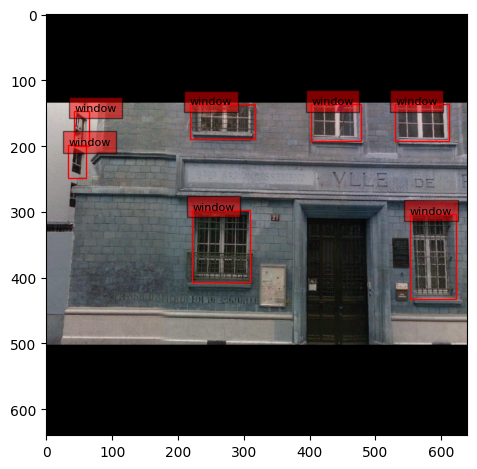

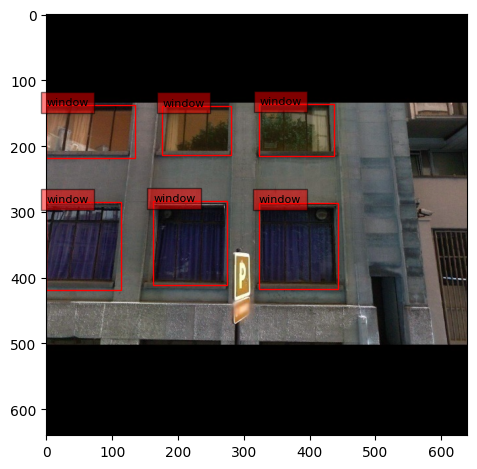

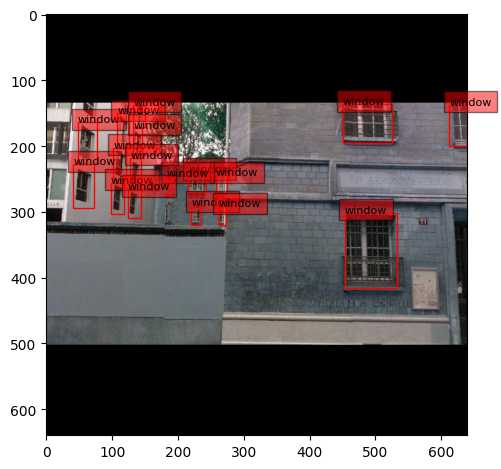

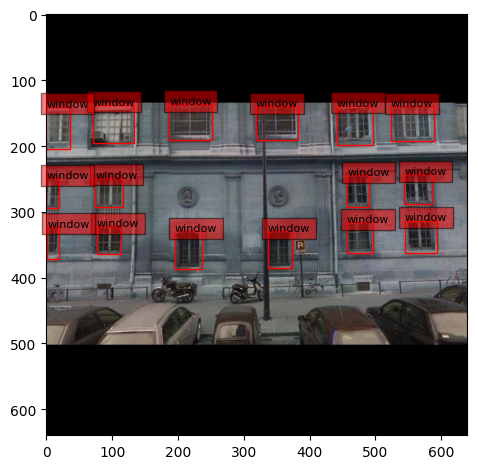

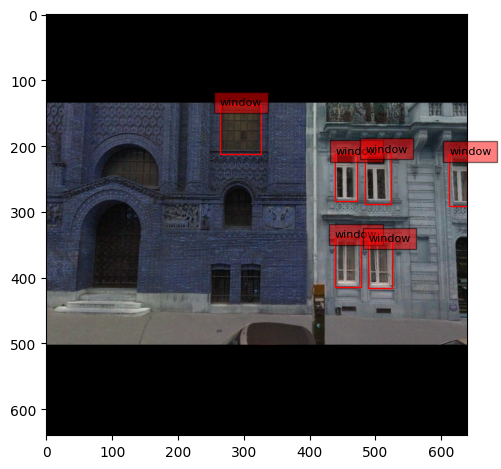

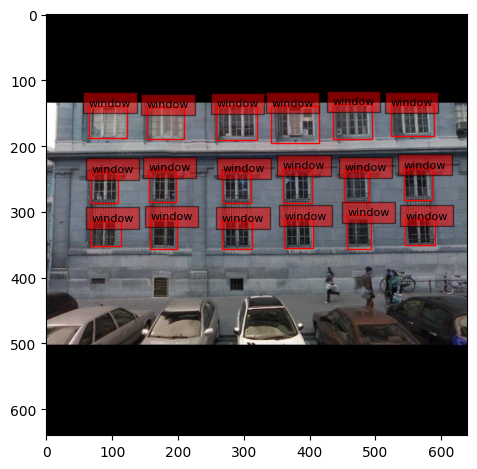

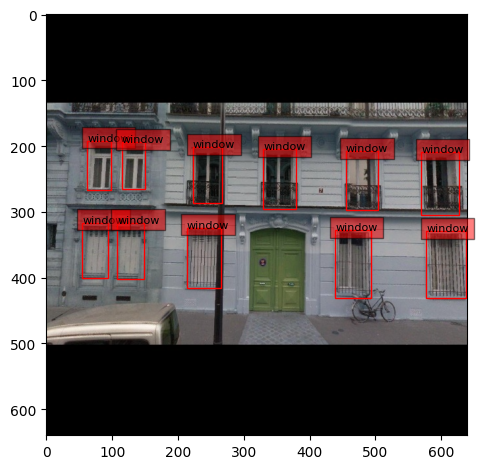

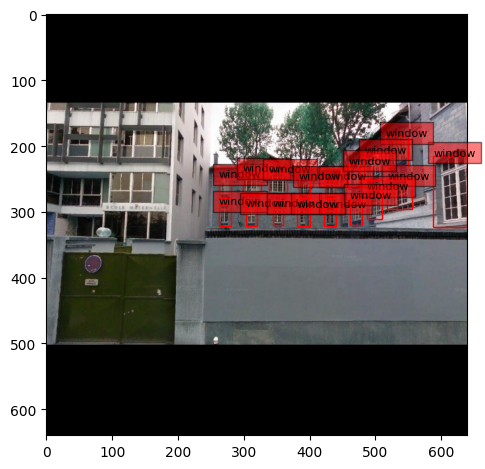

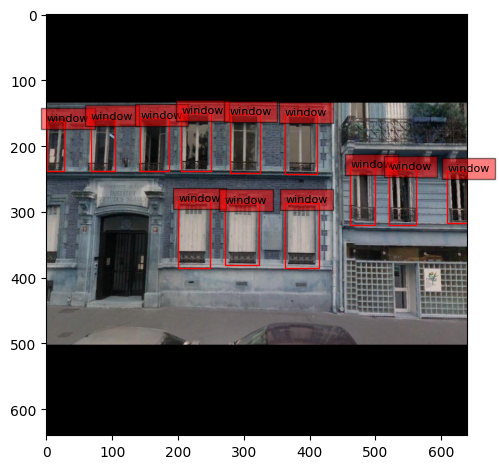

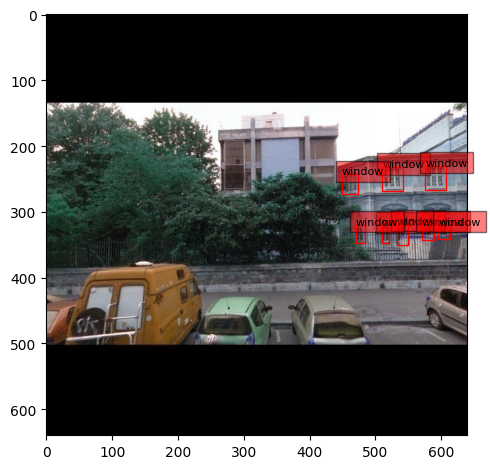

In [3]:
#displaying image with boxes
for i in range(10):
  figure, ax = plt.subplots()
  ax.imshow(images[i])

  for ele in range(len(annotes[i])):
    rect = patch.Rectangle((annotes[i][ele][1], annotes[i][ele][2]), annotes[i][ele][3] - annotes[i][ele][1], annotes[i][ele][4] - annotes[i][ele][2], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(annotes[i][ele][1], annotes[i][ele][2], annotes[i][ele][0], fontsize=8, bbox=dict(facecolor='r', alpha=0.5))
  plt.show()


In [4]:
#Converting annotations into suitable format for pretrained YOLO
yolo_annotes = []
yolo_anno_path = r"C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\dataset\Annotations_yolo"
for i in range(len(annotes)):
    
    dummy = []
    for ele in range(len(annotes[i])):
#         lbl = annotes[i][ele][0]
        lbl = 0
        x_cen = ((annotes[i][ele][1] + annotes[i][ele][3])/2)/img_size
        y_cen = ((annotes[i][ele][2] + annotes[i][ele][4])/2)/img_size
        width = (annotes[i][ele][3] - annotes[i][ele][1])/img_size
        height = (annotes[i][ele][4] - annotes[i][ele][2])/img_size
        annote_yolo = f'{lbl} {x_cen:.6f} {y_cen:.6f} {width:.6f} {height:.6f}'
        dummy.append(annote_yolo)
    op_filename = yolo_anno_filename[i]
    output_path = os.path.join(yolo_anno_path,op_filename)
    with open(output_path, 'w') as f:
        f.write('\n'.join(dummy))
    yolo_annotes.append(dummy)
    
print(yolo_annotes[1])

['0 0.105235 0.278205 0.210470 0.125000', '0 0.356838 0.275000 0.162393 0.116453', '0 0.594017 0.275000 0.177350 0.122863', '0 0.340812 0.543162 0.175214 0.199786', '0 0.598825 0.549038 0.189103 0.205128', '0 0.088141 0.550107 0.176282 0.209402']


Using cache found in C:\Users\gokul/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-4-23 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)



requirements: C:\Users\gokul\.cache\torch\hub\requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


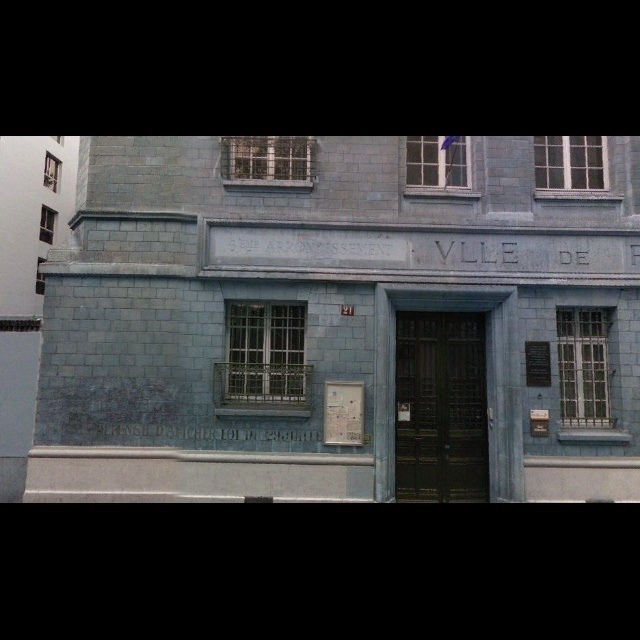

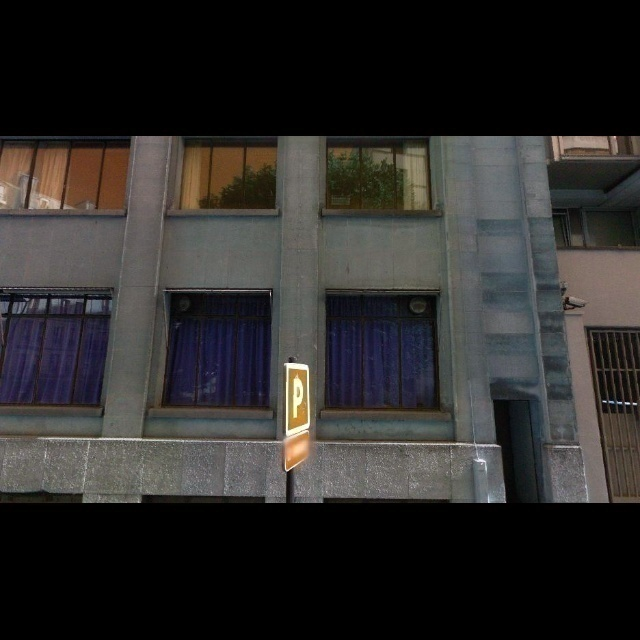

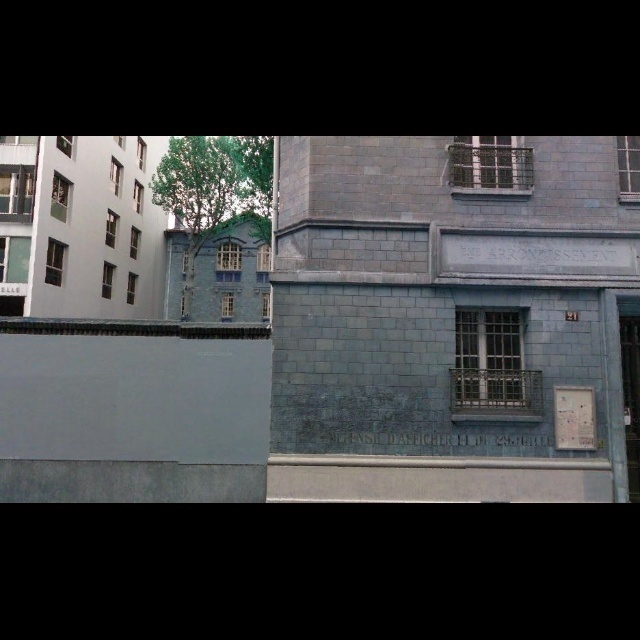

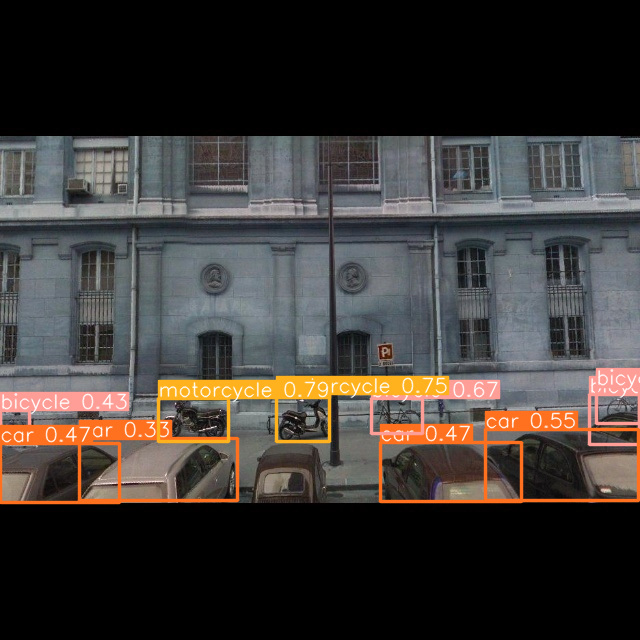

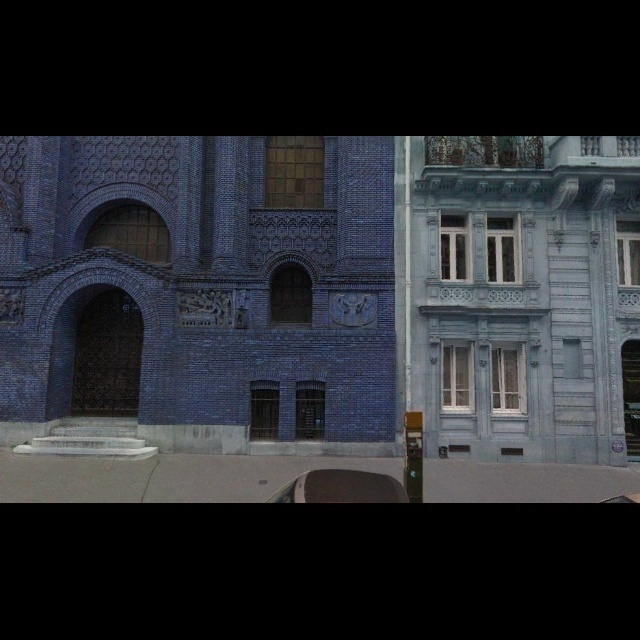

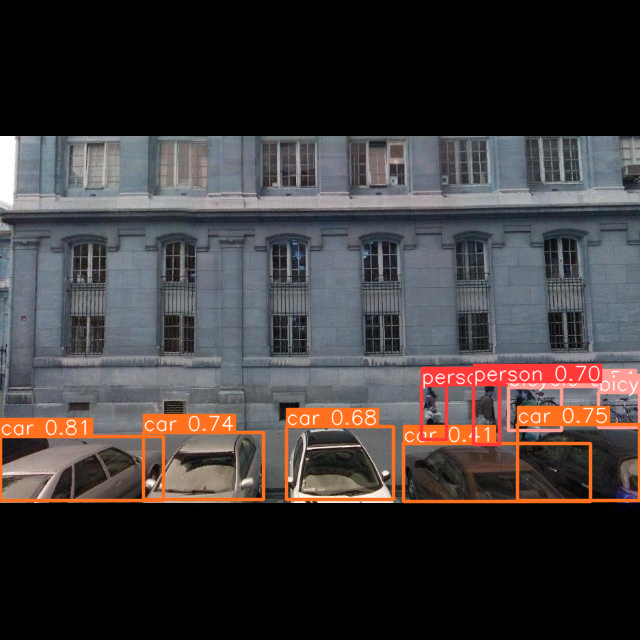

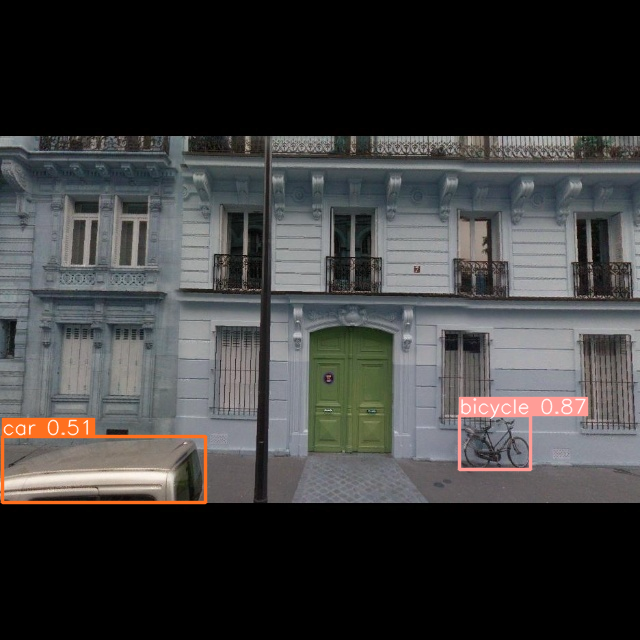

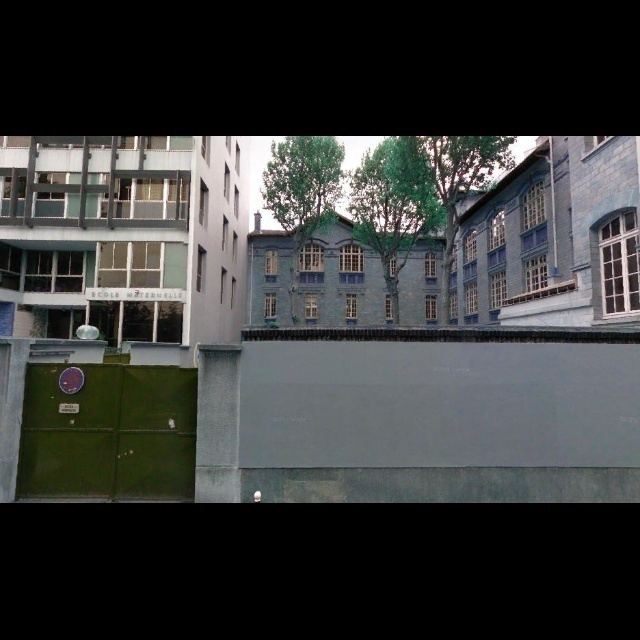

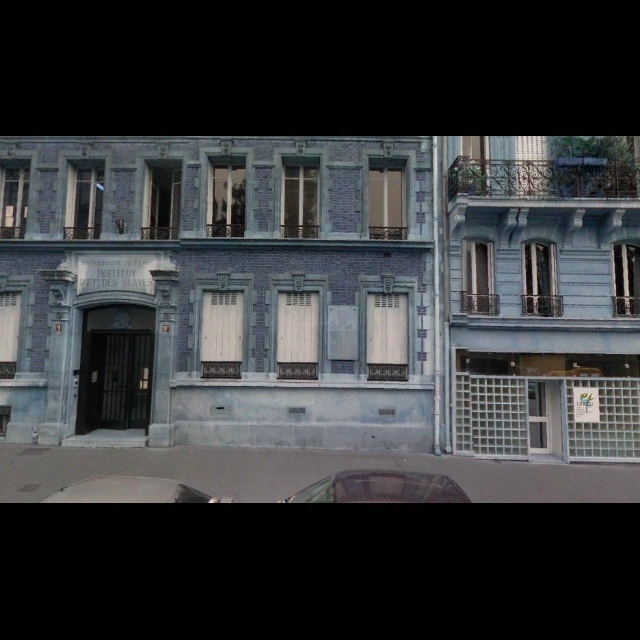

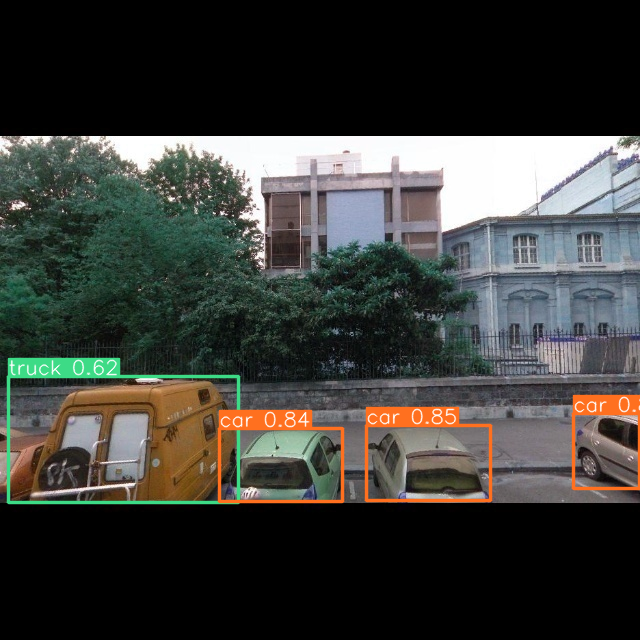

In [5]:
import torch
from PIL import Image
from torchvision import transforms
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained = True)
for img in images[:10]:
    pred_img = model(img)
    pred_img.show()

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

x_train,x_test,y_train,y_test = train_test_split(images,yolo_annotes,test_size=0.2, random_state = 50)

class cus_dataset(Dataset):
    
    def __init__(self, img_list, anno_list):
        self.image_list = img_list
        self.annote_list = anno_list
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        img_tensor = transforms.ToTensor(self.image_list[index])
        anno_tensor = transforms.ToTensor(self.annote_list[index])
        return img_tensor,anno_tensor



OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\gokul\.conda\envs\new_env_csis\lib\site-packages\torch\lib\cublas64_11.dll" or one of its dependencies.

In [7]:
from yolov5 import YOLOv5
train_dataset = cus_dataset(x_train,y_train)
dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
model_path = r"C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\yolov5s.pt"
yolo = YOLOv5(model_path)
yolo.train(dataloader)

YOLOv5  2023-4-23 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AttributeError: 'YOLOv5' object has no attribute 'train'

In [2]:
import os
os.environ['GIT_PYTHON_GIT_EXECUTABLE'] = r'C:\Program Files\Git\bin\git.exe'

os.environ['KMP_DUPLICATE_LIB_OK']='True'

%cd C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master

C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master


In [8]:
!C:\Users\gokul\.conda\envs\new_env_csis\python.exe train.py --img 640 --batch 5 --epochs 50 --data data/custom.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --cache --device 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


In [14]:
!C:\Users\gokul\.conda\envs\new_env_csis\python.exe detect.py --source C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset --weights C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\runs\train\exp46\weights\best.pt --img 640 --conf 0.5 --name NEW_detected_window_images

detect: weights=['C:\\Users\\gokul\\Desktop\\CSIS_SS23\\yolov5-master\\runs\\train\\exp46\\weights\\best.pt'], source=C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=NEW_detected_window_images, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2023-4-22 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7077550 parameters, 0 gradients, 16.0 GFLOPs
image 1/49 C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset\20001.jpg: 640x640 12 windowss, 9.0ms
image 2/49 C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dat

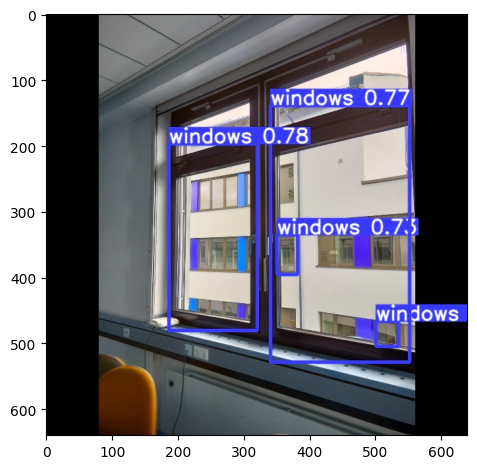

In [15]:
import random
detections_dir = r"runs\detect\NEW_detected_window_images2"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = cv.imread(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [2]:
#Empty list to store images and corresponding annotations in tuple/list format
images = []
annotes = []
yolo_anno_filename = []
img_size = 640
new_image_folder_path = r"C:\Users\gokul\Desktop\CSIS_SS23\classification_sample_test\images"
new_anno_folder_path = r"C:\Users\gokul\Desktop\CSIS_SS23\classification_sample_test\labels"
# sample_img = cv.imread(r'C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset\20001.jpg')
# a_scaling = min(img_size/sample_img.shape[0], img_size/sample_img.shape[1])
  
# #Resizing images

# a_new_h = int(sample_img.shape[0]*a_scaling)
# a_new_w = int(sample_img.shape[1]*a_scaling)

# #Padding
# a_pad_h = (img_size - a_new_h)//2
# a_pad_w = (img_size - a_new_w)//2

# print(a_scaling,a_pad_h)
#Reading each image and corresponding annotations

for img in os.listdir(new_image_folder_path):

    #reading images using openCV
    img_path = os.path.join(new_image_folder_path, img)
    image = cv.imread(img_path)

    #ToDO; clean redundant code written twice

    scaling = min(img_size/image.shape[0], img_size/image.shape[1])

    #Resizing images

    new_h = int(image.shape[0]*scaling)
    new_w = int(image.shape[1]*scaling)
    
    #resizing annotations
    a_scaling = min(img_size/image.shape[0], img_size/image.shape[1])

    a_new_h = int(image.shape[0]*a_scaling)
    a_new_w = int(image.shape[1]*a_scaling)

    #Padding
    a_pad_h = (img_size - a_new_h)//2
    a_pad_w = (img_size - a_new_w)//2
    
    #reading annotations
    anno_filename = os.path.splitext(img)[0] + ".xml"
    yolo_filename = os.path.splitext(img)[0] + ".txt"
    anno_path = os.path.join(new_anno_folder_path, anno_filename)
    yolo_anno_filename.append(yolo_filename)

    if not os.path.exists(anno_path):
        print(anno_path)
        raise ValueError(f"No file was found in the given path")
        

    #Function to get Bouding boxes from the annotations
    boxes = []
    tree = ET.parse(anno_path)
    root = tree.getroot()
    for objects in root.findall('object'):
        label = objects.find('name').text
        xmin = int(objects.find('bndbox/xmin').text)
        xmin_scaled = (xmin * a_scaling) + a_pad_w
        ymin = int(objects.find('bndbox/ymin').text)
        ymin_scaled = (ymin * a_scaling) + a_pad_h
        xmax = int(objects.find('bndbox/xmax').text)
        xmax_scaled = (xmax * a_scaling) + a_pad_w
        ymax = int(objects.find('bndbox/ymax').text)
        ymax_scaled = (ymax * a_scaling) + a_pad_h
        boxes.append([label,xmin_scaled,ymin_scaled,xmax_scaled,ymax_scaled])
    #     boxes.append([label,xmin,ymin,xmax,ymax])
    annotes.append(boxes)
    
    
    image_resized = cv.resize(image, (new_w,new_h))

    #Padding
    pad_h = (img_size - new_h)//2
    pad_w = (img_size - new_w)//2

    img_padded = cv.copyMakeBorder(image_resized,pad_h,img_size-new_h-pad_h,pad_w,img_size-new_w-pad_w,cv.BORDER_CONSTANT,value = (0,0,0))
    images.append(img_padded)
    cv.imwrite(img_path,img_padded)
print('Done')

Done


In [9]:
#Converting annotations into suitable format for pretrained YOLO
for i in range(10):
    print(annotes[i])
yolo_annotes = []
yolo_anno_path = r"C:\Users\gokul\Desktop\CSIS_SS23\classification_sample_test\labels_yolo"
new_lbl = 0
for i in range(len(annotes)):
    
    dummy = []
    for ele in range(len(annotes[i])):
        lbl = annotes[i][ele][0]
#         lbl = 0
        if lbl == 'closed':
            new_lbl = 0
        elif lbl == 'fully_open':
            new_lbl = 1
        elif lbl == 'semi_open':
            new_lbl = 2
        elif lbl == 'titled':
            new_lbl = 3
        else:
            print('error')

        x_cen = ((annotes[i][ele][1] + annotes[i][ele][3])/2)/img_size
        y_cen = ((annotes[i][ele][2] + annotes[i][ele][4])/2)/img_size
        width = (annotes[i][ele][3] - annotes[i][ele][1])/img_size
        height = (annotes[i][ele][4] - annotes[i][ele][2])/img_size
        annote_yolo = f'{new_lbl} {x_cen:.6f} {y_cen:.6f} {width:.6f} {height:.6f}'
        dummy.append(annote_yolo)
    op_filename = yolo_anno_filename[i]
    output_path = os.path.join(yolo_anno_path,op_filename)
    with open(output_path, 'w') as f:
        f.write('\n'.join(dummy))
    yolo_annotes.append(dummy)
    
print(yolo_annotes[169])

[['closed', 141.3840830449827, 29.75778546712803, 499.8615916955018, 452.31833910034607]]
[['titled', 143.87543252595157, 150.4498269896194, 499.8615916955018, 499.37716262975783]]
[['semi_open', 143.04498269896195, 4.982698961937716, 499.8615916955018, 490.38062283737025]]
[['fully_open', 141.3840830449827, 0.8304498269896194, 499.8615916955018, 487.8892733564014]]
[['closed', 142.21453287197232, 83.46020761245676, 499.8615916955018, 477.923875432526]]
[['titled', 142.21453287197232, 156.26297577854672, 499.8615916955018, 558.2006920415225]]
[['titled', 140.55363321799308, 166.22837370242215, 499.8615916955018, 567.1972318339101]]
[['titled', 142.21453287197232, 203.46020761245677, 491.97231833910035, 573.0103806228374]]
[['titled', 144.5674740484429, 189.34256055363323, 490.3114186851211, 549.8961937716264]]
[['semi_open', 194.25605536332182, 120.69204152249137, 495.29411764705884, 541.5916955017301]]
['2 0.467020 0.587803 0.466479 0.819204']


In [23]:
!C:\Users\gokul\.conda\envs\new_env_csis\python.exe detect.py --source C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset --weights C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\runs\train\exp51\weights\best.pt --img 640 --conf 0.25 --name class_detected_window_images

detect: weights=['C:\\Users\\gokul\\Desktop\\CSIS_SS23\\yolov5-master\\runs\\train\\exp51\\weights\\best.pt'], source=C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=class_detected_window_images, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  2023-4-22 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7118005 parameters, 0 gradients, 16.1 GFLOPs
image 1/49 C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\custom_dataset\20001.jpg: 640x640 (no detections), 0.0ms
image 2/49 C:\Users\gokul\Desktop\CSIS_SS23\windows_dataset_kaggle\cus

In [10]:
#Classification model
!C:\Users\gokul\.conda\envs\new_env_csis\python.exe C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\classify\train.py --model C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\runs\train\exp46\weights\best.pt --data C:\Users\gokul\Desktop\CSIS_SS23\classification_sample_test\images --epochs 5 --img 640 --device 0


github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


classify\train: model=C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\runs\train\exp46\weights\best.pt, data=C:\Users\gokul\Desktop\CSIS_SS23\classification_sample_test\images, epochs=5, batch_size=64, imgsz=640, nosave=False, cache=None, device=0, workers=8, project=runs\train-cls, name=exp, exist_ok=False, pretrained=True, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
YOLOv5  2023-4-22 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

TensorBoard: Start with 'tensorboard --logdir runs\train-cls', view at http://localhost:6006/
Traceback (most recent call last):
  File "C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\classify\train.py", line 335, in <module>
    main(opt)
  File "C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\classify\train.py", line 321, in main
    train(opt, device)
  File "C:\Users\gokul\Desktop\CSIS_SS23\yolov5-master\classify\train.py", line 90, in tr

In [22]:
!C:\Users\gokul\.conda\envs\new_env_csis\python.exe train.py --img 640 --batch 5 --epochs 50 --data data\custom_cls.yaml --cfg models\yolov5s.yaml --weights runs\train\exp46\weights\best.pt --cache --device 0

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5


train: weights=runs\train\exp46\weights\best.pt, cfg=models\yolov5s.yaml, data=data\custom_cls.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=50, batch_size=5, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5  2023-4-22 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 